## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import SVG, Markdown, display, display_pretty
pd.set_option('display.max_columns', None)

from train import *
from test import *
from layers import *
from utils import *
from loss import *

In [2]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Test experiment

In [3]:
data_microbioma_train, data_microbioma_test, data_domain_train, data_domain_test, \
otu_columns, domain_columns = read_data(otu_filename='data/Aggregated/otu_table_Phylum.csv',
                                        metadata_filename='data/Aggregated/metadata_table_all_80.csv')



In [4]:
def perform_experiment(cv_folds, epochs, batch_size, learning_rate, optimizer,
                       learning_rate_scheduler, input_transform, output_transform,
                       reconstruction_loss, latent_space, layers,
                       activation, activation_latent, show_results=False, device='/CPU:0'):
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    if reconstruction_loss.__class__.__name__ == 'MakeLoss':
        reconstruction_loss = reconstruction_loss.make()
    else:
        reconstruction_loss = reconstruction_loss()
    domain_layers = [l // 16 for l in layers]
    bioma_autoencoder = " -> ".join(["b"] +
                                    [str(l) for l in layers] +
                                    [str(latent_space)] +
                                    [str(l) for l in reversed(layers)] +
                                    ["b"])
    domain_autoencoder = " -> ".join(["d"] +
                                     [str(l) for l in domain_layers] +
                                     [str(latent_space)] +
                                     [str(l) for l in reversed(layers)] +
                                     ["b"])
    in_transform_name = input_transform.__class__.__name__ if input_transform else "none"
    out_transform_name = output_transform.__class__.__name__ if output_transform else "none"
    lr_scheduler_text = learning_rate_scheduler[1] if learning_rate_scheduler is not None else "none"
    lr_text = learning_rate if learning_rate_scheduler is not None else "constant = {}".format(
        learning_rate)
    learning_rate_scheduler = learning_rate_scheduler[
        0] if learning_rate_scheduler is not None else None
    optimizer = optimizer(learning_rate=learning_rate)
    experiment_parameters = [
        ("Input transform", in_transform_name),
        ("Output transform", out_transform_name),
        ("Reconstruction Loss", reconstruction_loss.__class__.__name__),
        ("Latent Space", latent_space),
        ("Bioma Autoencoder", bioma_autoencoder),
        ("Domain Autoencoder", domain_autoencoder),
        ("Activation Encoder", activation),
        ("Activation Decoder", activation),
        ("Activation Latent", activation_latent),
        ("CV folds", cv_folds),
        ("Epochs", epochs),
        ("Batch Size", batch_size),
        ("Learning Rate Scheduler", lr_scheduler_text),
        ("Learning Rate", lr_text),
        ("Optimizer", optimizer.__class__.__name__),
    ]

    if show_results:
        md_text = ""
        md_text += "| Parameter             | Value         |\n"
        md_text += "|:----------------------|:--------------|\n"
        for n, v in experiment_parameters:
            md_text += "| {} | {} |\n".format(n, v)

        display(Markdown(md_text))

    def create_model(print_data=False):

        models = autoencoder(bioma_shape=16,
                             domain_shape=36,
                             output_shape=16,
                             latent_space=latent_space,
                             bioma_layers=layers,
                             domain_layers=domain_layers,
                             input_transform=input_transform,
                             output_transform=output_transform,
                             activation_function_encoder=activation,
                             activation_function_decoder=activation,
                             activation_function_latent=activation_latent)
        model, encoder_bioma, encoder_domain, decoder_bioma = models

        if print_data:
            plot_models(model, encoder_bioma, encoder_domain, decoder_bioma)
        compile_train(model,
                      encoder_bioma=encoder_bioma,
                      encoder_domain=encoder_domain,
                      reconstruction_error=reconstruction_loss,
                      encoded_comparison_error=losses.MeanAbsoluteError(),
                      metrics=get_experiment_metrics(input_transform, output_transform),
                      optimizer=optimizer)

        return model, encoder_bioma, encoder_domain, decoder_bioma

    create_model(print_data=False)

    with tf.device(device):
        results, models = train(create_model,
                                data_microbioma_train,
                                data_domain_train,
                                latent_space=latent_space,
                                folds=cv_folds,
                                epochs=epochs,
                                batch_size=batch_size,
                                learning_rate_scheduler=learning_rate_scheduler,
                                verbose=-1)

    validation_results = print_results(results, show_results=show_results)
    if show_results:
        display(Markdown("*************"))

    return experiment_parameters + validation_results, models, results

def test_experiment(models, input_transform, output_transform, show=True):
    data_bioma_test_transformed = data_microbioma_test
    if input_transform is not None:
        input_transform = input_transform()
        data_bioma_test_transformed = input_transform(data_microbioma_test)
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[1][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        _, _, encoder_domain, decoder_bioma = cv_models
        encoded = encoder_domain.predict(data_domain_test)
        decoded = decoder_bioma.predict(encoded)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(data_microbioma_test, decoded)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        all_predictions.append(decoded)
        # otus error
        se = tf.math.squared_difference(decoded, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    if show:
        md_text = "## Test results \n"
        md_text += "| Metric           | Mean    | Min     | Max     |\n"
        md_text += "|:-----------------|--------:|--------:|--------:|\n"
        for k, v in metrics_results.items():
            md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])

        display(Markdown(md_text))

        md_text ="### Best Otus\n"
        md_text += "| OTU | mse |\n"
        md_text += "|:----|----:|\n"
        for v, k in mse_otus_keys[:10]:
            md_text += "| {} | {} |\n".format(k, v)
        md_text += "\n\n"
        md_text +="### Worst Otus\n"
        md_text += "| OTU | mse |\n"
        md_text += "|:----|----:|\n"
        for v, k in reversed(mse_otus_keys[-10:]):
            md_text += "| {} | {} |\n".format(k, v)

        display(Markdown(md_text))

    final_predictions = np.mean(all_predictions,axis=0)
    return metrics_results, final_predictions

def perform_test_experiment(cv_folds, epochs, batch_size, learning_rate, optimizer,
                           learning_rate_scheduler, input_transform, output_transform,
                           reconstruction_loss, latent_space, layers,
                           activation, activation_latent, show_results=False, device='/CPU:0',
                            filename_predictions=None):
    summary, models, results = perform_experiment(cv_folds, epochs, batch_size, learning_rate,
                                                  optimizer, learning_rate_scheduler,
                                                  input_transform, output_transform,
                                                  reconstruction_loss, latent_space, layers,
                                                  activation, activation_latent,
                                                  show_results, device)
    metrics_test, final_predictions = test_experiment(models,
                                                      input_transform=input_transform,
                                                      output_transform=output_transform)
    if filename_predictions is not None:
        save_predictions(final_predictions, filename_predictions)
    return models, metrics_test

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 128 -> 10 -> 128 -> b |
| Domain Autoencoder | d -> 8 -> 10 -> 128 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 5 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>93</b></p>

<b>loss</b>: 0.2628 (min: 0.2407, max: 0.2907)

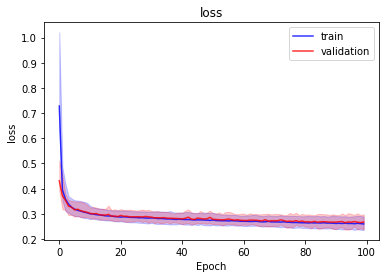

<b>bioma_loss</b>: 0.0525 (min: 0.0482, max: 0.0558)

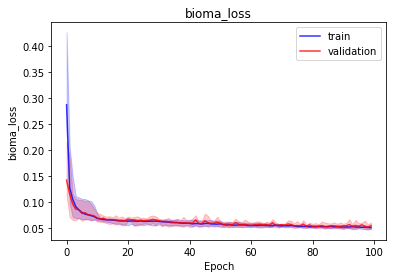

<b>domain_loss</b>: 0.1954 (min: 0.1713, max: 0.2233)

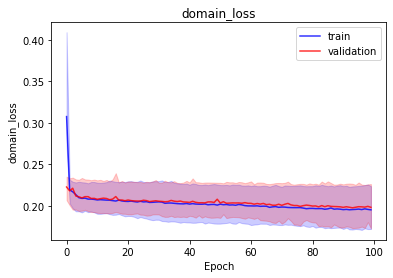

<b>latent_loss</b>: 0.0150 (min: 0.0128, max: 0.0167)

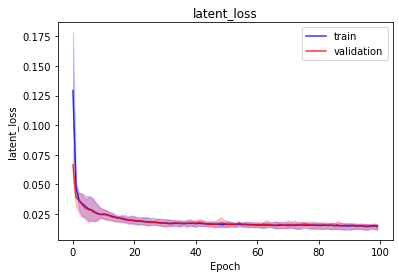

<b>bioma_mse</b>: 0.0003 (min: 0.0002, max: 0.0003)

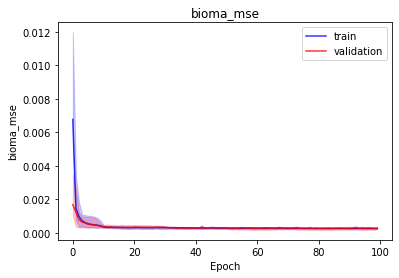

<b>bioma_mae</b>: 0.0063 (min: 0.0058, max: 0.0065)

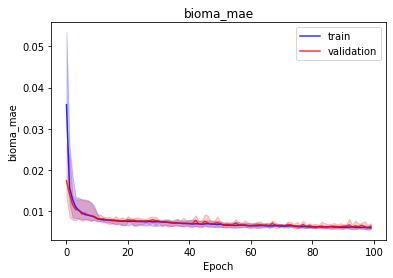

<b>bioma_mape</b>: 45219.1133 (min: 43190.0078, max: 48801.9258)

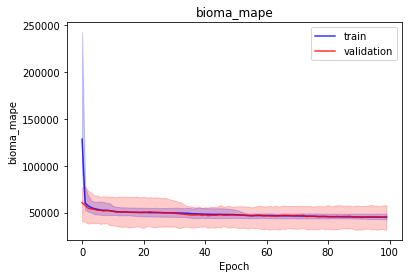

<b>bioma_BrayCurtis</b>: 0.0524 (min: 0.0483, max: 0.0543)

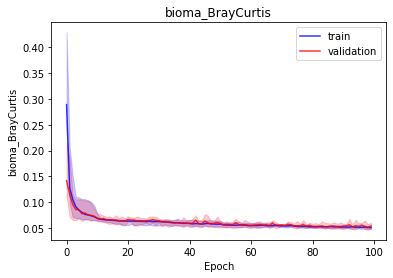

<b>bioma_pearson_corr</b>: nan (min: nan, max: nan)

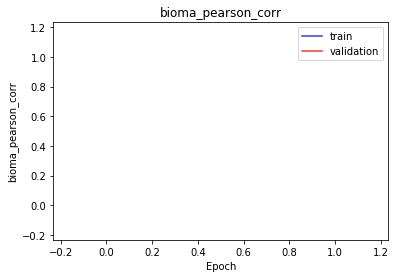

<b>bioma_jensen_shannon_divergence</b>: 0.0645 (min: 0.0617, max: 0.0682)

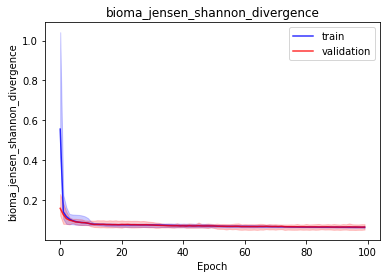

<b>domain_mse</b>: 0.0037 (min: 0.0030, max: 0.0044)

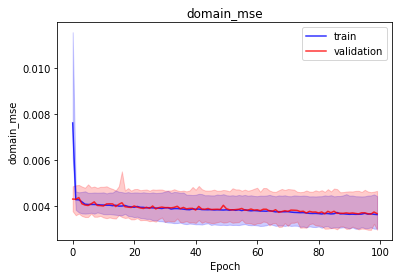

<b>domain_mae</b>: 0.0242 (min: 0.0212, max: 0.0277)

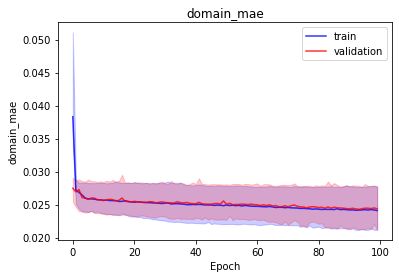

<b>domain_mape</b>: 63357.9141 (min: 56959.7031, max: 72087.4531)

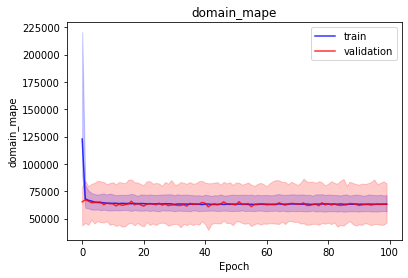

<b>domain_BrayCurtis</b>: 0.1955 (min: 0.1716, max: 0.2236)

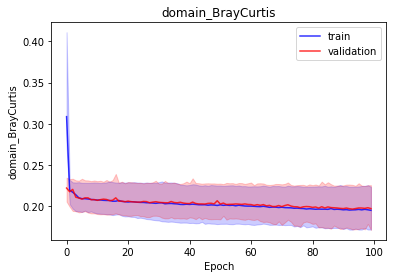

<b>domain_pearson_corr</b>: nan (min: nan, max: nan)

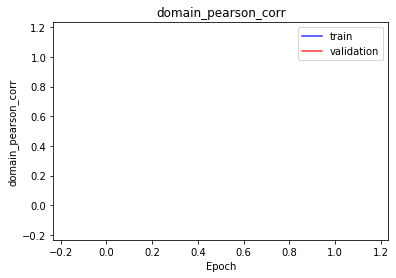

<b>domain_jensen_shannon_divergence</b>: 0.2082 (min: 0.1785, max: 0.2456)

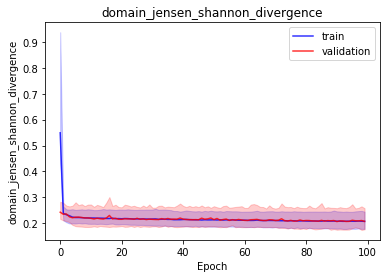

<b>latent_mae</b>: 0.0150 (min: 0.0129, max: 0.0167)

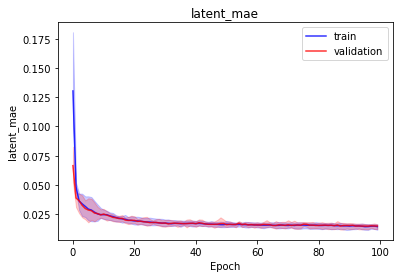

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.26283274128491185 | 0.24070153251986964 | 0.2907368239586019 |
| bioma_loss | 0.05250130221247673 | 0.048232607543468475 | 0.05575110763311386 |
| domain_loss | 0.1953793466091156 | 0.17125330865383148 | 0.22331416606903076 |
| latent_loss | 0.01498633436858654 | 0.01281803660094738 | 0.01667633466422558 |
| bioma_mse | 0.0002571238437667489 | 0.0002337288751732558 | 0.0002939555561169982 |
| bioma_mae | 0.006282328628003597 | 0.005776527803391218 | 0.006549547892063856 |
| bioma_mape | 45219.11328125 | 43190.0078125 | 48801.92578125 |
| bioma_BrayCurtis | 0.05237530544400215 | 0.048270002007484436 | 0.054307084530591965 |
| bioma_pearson_corr | nan | nan | nan |
| bioma_jensen_shannon_divergence | 0.06452950835227966 | 0.06166410446166992 | 0.06816291064023972 |
| domain_mse | 0.0036633640993386507 | 0.0030437414534389973 | 0.0044407956302165985 |
| domain_mae | 0.024168331176042557 | 0.02116956003010273 | 0.027672255411744118 |
| domain_mape | 63357.9140625 | 56959.703125 | 72087.453125 |
| domain_BrayCurtis | 0.1954621970653534 | 0.17156025767326355 | 0.2235814929008484 |
| domain_pearson_corr | nan | nan | nan |
| domain_jensen_shannon_divergence | 0.20820477604866028 | 0.1784663051366806 | 0.24562551081180573 |
| latent_mae | 0.01499524712562561 | 0.01286076195538044 | 0.016732262447476387 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.19547481834888458 | 0.17283891141414642 | 0.22235585749149323 |
| pearson_corr | nan | nan | nan |
| jensen_shannon_divergence | 0.18658943474292755 | 0.1616028994321823 | 0.21560050547122955 |


### Best Otus
| OTU | mse |
|:----|----:|
| 256569 | 4.202549348519824e-07 |
| 357721 | 6.739245463904808e-07 |
| 217700 | 3.5575201309256954e-06 |
| 585878 | 7.686958269914612e-06 |
| 1081222 | 9.57844440563349e-06 |
| 537655 | 1.15977327368455e-05 |
| 4469039 | 2.160205076506827e-05 |
| 1081489 | 2.3293754566111602e-05 |
| 556561 | 0.00019513278675731272 |
| 221349 | 0.0002847813884727657 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 646549 | 0.03518737480044365 |
| 4339351 | 0.017842713743448257 |
| 368218 | 0.0028779045678675175 |
| 226240 | 0.0009585510706529021 |
| 3609950 | 0.0008914616191759706 |
| 112867 | 0.0003117498417850584 |
| 221349 | 0.0002847813884727657 |
| 556561 | 0.00019513278675731272 |
| 1081489 | 2.3293754566111602e-05 |
| 4469039 | 2.160205076506827e-05 |


In [5]:
models, _ = perform_test_experiment(cv_folds=5, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[128],
                        activation='tanh', 
                        activation_latent='tanh', 
                        show_results=True, 
                        device='/CPU:0',
                       filename_predictions='predictions_agregated_phylum.txt')

# Transfer Learning

In [6]:
encoders = []
decoders = []
for cv_models in models:
    model, encoder, _, decoder = cv_models
    encoders.append(encoder)
    decoders.append(decoder)
    
def make_cv_predictions(data, models):
    all_predictions = []
    for m in models:
        all_predictions.append(m.predict(data))
    return np.mean(all_predictions, axis=0)

In [7]:
from sklearn.model_selection import train_test_split

def read_transfer_data(random_state=42,
              otu_filename='data/TransferLearning/155samples/otu_table_Maarastawi2018_Phylum.csv',
              metadata_filename='data/TransferLearning/155samples/metadata_table_Maarastawi2018_Phylum.csv'):
    otu = pd.read_csv(otu_filename, index_col=0, header=None, sep='\t').T
    metadata = pd.read_csv(metadata_filename, sep='\t')
    metadata = metadata.set_index('X.SampleID')
    domain = metadata[['pH', 'Nmin', 'N', 'C', 'C.N', 'Corg', 'soil_type', 'clay_fration', 'water_holding_capacity']]
    domain = pd.concat([domain, pd.get_dummies(domain['soil_type'], prefix='soil_type')], axis=1)
    domain = domain.reset_index()
    domain = domain.drop(['X.SampleID','soil_type'], axis=1)
    otu = otu.reset_index()
    otu = otu.drop(['otuids','index'], axis=1)
    otu = otu.astype('int32')
    df = pd.concat([otu, domain], axis=1, sort=True, join='outer')
    df = df.dropna(subset=['pH', 'Nmin', 'N', 'C', 'C.N', 'Corg', 'clay_fration', 'water_holding_capacity'])
    data_microbioma = df[otu.columns].to_numpy(dtype=np.float32)
    data_domain = df[domain.columns].to_numpy(dtype=np.float32)
    data_microbioma_train, data_microbioma_test, data_domain_train, data_domain_test = \
        train_test_split(data_microbioma, data_domain, test_size=0.3, random_state=random_state)
    return data_microbioma_train, data_microbioma_test, data_domain_train, data_domain_test, otu.columns, domain.columns

In [27]:
data_microbioma_train, data_microbioma_test, data_domain_train, data_domain_test, otu_columns, domain_columns =\
read_transfer_data()

In [28]:
data_microbioma_train.shape

(86, 16)

In [29]:
data_domain_train.shape

(86, 12)

In [30]:
train_encoded = make_cv_predictions(data_microbioma_train, encoders)
test_encoded = make_cv_predictions(data_microbioma_test, encoders)

In [31]:
from tensorflow import keras

def model_fn_2():
    in_layer = layers.Input(shape=(12,))
    net = layers.Dense(64, activation=None)(in_layer)
    out_layer = layers.Dense(train_encoded.shape[1], activation=None)(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [32]:
def train_2(model_fn,
          data_encoded,
          data_domain,
          folds=5,
          epochs=100,
          batch_size=16,
          random_seed=347,
          verbose=0):
    kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]

    tf.random.set_seed(random_seed)

    for train_index, test_index in kf.split(data_domain):
        y_train, y_test = data_encoded[train_index], data_encoded[test_index]
        x_train, x_test = data_domain[train_index], data_domain[test_index]
        model = model_fn()
        metrics_prefix = 'domain'

        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
            batch_size)
        train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
        val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        r = model.fit(train_dataset,
                      epochs=epochs,
                      validation_data=val_dataset,
                      callbacks=train_callbacks,
                      verbose=0)
        if metrics_prefix is not None:
            old_keys = r.history
            r.history = {}
            for k, v in old_keys.items():
                if k == 'loss' or k == 'val_loss':
                    new_key = k
                elif k.startswith('val_'):
                    new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
                else:
                    new_key = '{}_{}'.format(metrics_prefix, k)
                r.history[new_key] = v
        results.append(r)
        models.append(model)
    return results, models

In [33]:
train_encoded.shape

(86, 10)

In [34]:
data_domain_train.shape

(86, 12)

In [41]:
results, models = train_2(model_fn_2,
                        train_encoded,
                        data_domain_train,
                        folds=5,
                        epochs=200,
                        batch_size=16,
                        verbose=-1)

<p>Best iteration: <b>196</b></p>

<b>loss</b>: 0.0072 (min: 0.0029, max: 0.0161)

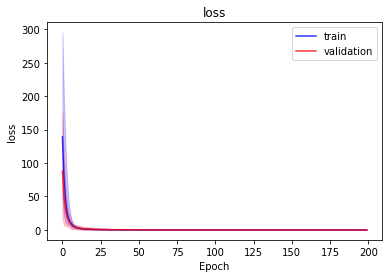

<b>domain_mean_squared_error</b>: 0.0072 (min: 0.0029, max: 0.0161)

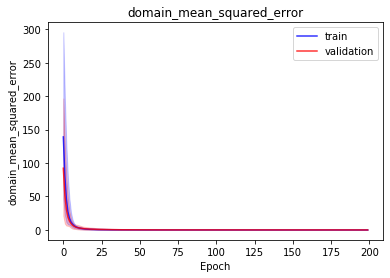

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.007168916100596426 | 0.0028877194592918176 | 0.01606036092647735 |
| domain_mean_squared_error | 0.007168916054069996 | 0.0028877193108201027 | 0.0160603616386652 |


[('best_lost_epoch', 196),
 ('val_loss',
  [0.007684200508811046, 0.001467390924517531, 0.023425252176821232]),
 ('val_domain_mean_squared_error', [0.010542574, 0.0026234963, 0.028855927])]

In [42]:
print_results(results)

In [43]:
def test_model_2(models, input_transform, output_transform):
    data_bioma_test_transformed = Percentage()(data_microbioma_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for model in models:
        predictions = model.predict(data_domain_test)
        all_predictions.append(predictions)
    final_predictions = np.mean(all_predictions,axis=0)
    
    final_decoded = make_cv_predictions(final_predictions, decoders)
    predictions = tf.nn.softmax(final_decoded)
    for m in metrics:
        if m.name not in metrics_results:
            metrics_results[m.name] = []
        result = m(data_microbioma_test, final_decoded)
        metrics_results[m.name] =result.numpy()
    # otus error
    se = tf.math.squared_difference(final_decoded, data_bioma_test_transformed)
    mse_otus = tf.reduce_mean(se, axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    return predictions

In [44]:
predictions = test_model_2(models, CenterLogRatio, None)
save_predictions(predictions, 'transfer_learning_autoencoder.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.6255137324333191 | 0.6255137324333191 | 0.6255137324333191 |
| pearson_corr | nan | nan | nan |
| jensen_shannon_divergence | 2.612305164337158 | 2.612305164337158 | 2.612305164337158 |


### Best Otus
| OTU | mse |
|:----|----:|
| 556561 | 5.831590897287242e-05 |
| 221349 | 8.338810584973544e-05 |
| 217700 | 0.00013092820881865919 |
| 357721 | 0.00023221810988616198 |
| 1081222 | 0.0002374699106439948 |
| 585878 | 0.00030254374723881483 |
| 1081489 | 0.0009457459673285484 |
| 226240 | 0.0058977678418159485 |
| 3609950 | 0.006858692970126867 |
| 537655 | 0.007312063593417406 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 256569 | 0.15477769076824188 |
| 4339351 | 0.0875740796327591 |
| 646549 | 0.0785718634724617 |
| 112867 | 0.057493988424539566 |
| 368218 | 0.010832052677869797 |
| 4469039 | 0.008729581721127033 |
| 537655 | 0.007312063593417406 |
| 3609950 | 0.006858692970126867 |
| 226240 | 0.0058977678418159485 |
| 1081489 | 0.0009457459673285484 |


## Linear regresion

In [20]:
def model_3(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation=None)(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model_3(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [21]:
def model_fn_3():
    m = model_3(shape_in=data_domain_train.shape[1],
              shape_out=data_microbioma_train.shape[1],
              output_transform=None,
              layers_list=[64],
              activation_fn='tanh')
    
    compile_model_3(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [23]:
results, models = train(model_fn_3,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=10,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>99</b></p>

<b>loss</b>: 1.9771 (min: 1.8173, max: 2.1069)

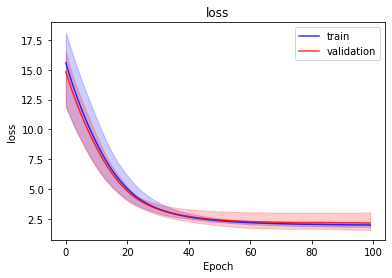

<b>domain_BrayCurtis</b>: 0.2649 (min: 0.2506, max: 0.2780)

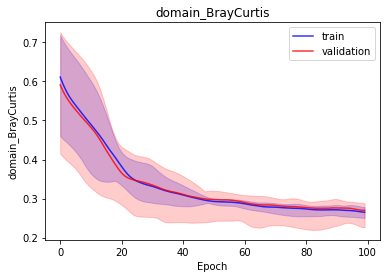

<b>domain_pearson_corr</b>: nan (min: nan, max: nan)

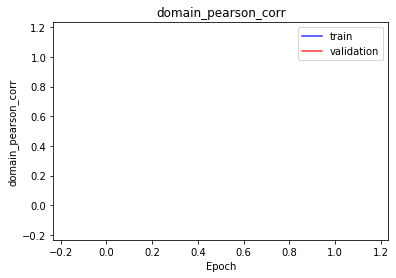

<b>domain_jensen_shannon_divergence</b>: 0.6564 (min: 0.6090, max: 0.7098)

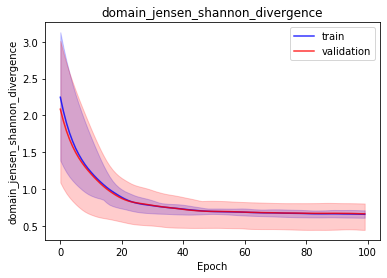

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 1.97708189420383 | 1.8172577740489573 | 2.1068769019583 |
| domain_BrayCurtis | 0.26493293046951294 | 0.2506338059902191 | 0.2780415415763855 |
| domain_pearson_corr | nan | nan | nan |
| domain_jensen_shannon_divergence | 0.6563836336135864 | 0.6089980006217957 | 0.709830105304718 |


[('best_lost_epoch', 99),
 ('val_loss', [2.150444436073303, 1.569048523902893, 3.037963390350342]),
 ('val_domain_BrayCurtis', [0.26958624, 0.22643864, 0.2879652]),
 ('val_domain_pearson_corr', [nan, nan, nan]),
 ('val_domain_jensen_shannon_divergence', [0.66247594, 0.4440036, 0.80294627])]

In [24]:
print_results(results)

In [25]:
def test_model_3(models, input_transform, output_transform):
    data_bioma_test_transformed = Percentage()(data_microbioma_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        model, _, _, _ = cv_models
        predictions = model.predict(data_domain_test)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(data_microbioma_test, predictions)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        predictions = tf.nn.softmax(predictions)
        all_predictions.append(predictions)
        # otus error
        se = tf.math.squared_difference(predictions, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    final_predictions = np.mean(all_predictions,axis=0)
    return final_predictions

In [26]:
predictions = test_model_3(models, CenterLogRatio, None)
save_predictions(predictions, 'transfer_learning_linear_regresion.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.30770862102508545 | 0.2968886196613312 | 0.32475826144218445 |
| pearson_corr | nan | nan | nan |
| jensen_shannon_divergence | 0.9258085489273071 | 0.9120672941207886 | 0.9515100717544556 |


### Best Otus
| OTU | mse |
|:----|----:|
| 585878 | 4.4872883186997115e-11 |
| 256569 | 7.401883272972754e-11 |
| 556561 | 5.326926810766963e-08 |
| 1081489 | 9.419342461569613e-08 |
| 357721 | 2.2075070660321217e-07 |
| 537655 | 3.6404908314580098e-06 |
| 217700 | 5.682629853254184e-05 |
| 221349 | 0.00012786223669536412 |
| 1081222 | 0.00042203316115774214 |
| 4339351 | 0.0014145165914669633 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 646549 | 0.026698213070631027 |
| 112867 | 0.021233145147562027 |
| 368218 | 0.007049123756587505 |
| 3609950 | 0.0042297267355024815 |
| 4469039 | 0.0026820297352969646 |
| 226240 | 0.002102858619764447 |
| 4339351 | 0.0014145165914669633 |
| 1081222 | 0.00042203316115774214 |
| 221349 | 0.00012786223669536412 |
| 217700 | 5.682629853254184e-05 |
